In [30]:
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

import json
import argparse
import gzip
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
sys.path.append('../scripts')
from utils import Bible, Location

def get_color(value, cmap):
    # return the color as a hue, saturation, value tuple
    return cmap(value)

# get_color(0.5, cm)

ENG = Bible('../human_translations/old_English_human.jsonl')
print(ENG[Location({"book": "GEN", "chapter": 1, "verse": 1})])


    

In the beginning God created the heaven and the earth.


In [4]:
# HACK:
# given a start Location and a length n, we want to retrieve the passage
# try to increment verses, if we reach the end of the chapter, increment chapter
# if we reach the end of the book, increment book
def retrieve_passage(start, n):
    # start is a Location object
    # n is an integer
    # returns a string
    current = start
    passage = [ENG[current]]
    for i in range(n-1):
        current = Location({"book": current['book'], "chapter": current['chapter'], "verse": current['verse'] + 1})
        if current not in ENG:
            current = Location({"book": current['book'], "chapter": current['chapter'] + 1, "verse": 1})
        passage.append(ENG[current])
    return passage


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--score", dest="score", help="Work directory")
#     parser.add_argument("--embedding", dest="embeddings", help="Embeddings file")
#     parser.add_argument("--output", dest="output", help="Output file")
#     parser.add_argument("--thres", dest="thres", type=float, help="Threshold for significance")

#     args = parser.parse_args()

score = '../chiasm_score_new_alg/work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz'



with gzip.open(score, "rb") as ifd:
    data = [json.loads(line) for line in ifd]

scores = pd.DataFrame.from_records(data)
# convert start and end columns to Location objects
scores["start"] = scores["start"].apply(lambda x: Location(x))
scores["end"] = scores["end"].apply(lambda x: Location(x))
print(scores.head())

   n  i         p  candidate_score                                      start  \
0  4  0  0.945055        -0.134080  {'book': 'GEN', 'chapter': 1, 'verse': 1}   
1  4  1  0.796204        -0.078728  {'book': 'GEN', 'chapter': 1, 'verse': 1}   
2  4  2  0.429570        -0.002652  {'book': 'GEN', 'chapter': 1, 'verse': 2}   
3  4  3  0.039960         0.166980  {'book': 'GEN', 'chapter': 1, 'verse': 3}   
4  4  4  0.784216        -0.075714  {'book': 'GEN', 'chapter': 1, 'verse': 4}   

                                         end  
0  {'book': 'GEN', 'chapter': 1, 'verse': 3}  
1  {'book': 'GEN', 'chapter': 1, 'verse': 4}  
2  {'book': 'GEN', 'chapter': 1, 'verse': 5}  
3  {'book': 'GEN', 'chapter': 1, 'verse': 6}  
4  {'book': 'GEN', 'chapter': 1, 'verse': 7}  


In [5]:
embedding = "../Greek-embedded.json.gz"
locations = []
embeds = []
with gzip.open(embedding, "rb") as ifd:
    for line in ifd:
        obj = json.loads(line)
        locations.append(Location(obj['location']))
        embeds.append(obj['embedding'])
    locations = np.asarray(locations)
    embeds = np.asarray(embeds)

cos_sim = cosine_similarity(embeds,embeds)
print(cos_sim.shape)


(23313, 23313)


In [74]:
# {'book': '1KI', 'chapter': 12, 'verse': 11}
score = scores[(scores['start'] == {'book': '2CH', 'chapter': 10, 'verse': 11}) & (scores['n'] == 4)]
# score = scores[(scores['start'] == {'book': '1KI', 'chapter': 12, 'verse': 11}) & (scores['n'] == 4)]
# score = scores[(scores['start'] == {'book': 'NUM', 'chapter': 35, 'verse': 1}) & (scores['n'] == 9)]
score_idx = score['i']
print(score, score_idx)

score['text'] = score.apply(lambda x: retrieve_passage(x['start'], x['n']), axis=1)


       n      i         p  candidate_score  \
11413  4  11413  0.000999         0.367638   

                                             start  \
11413  {'book': '2CH', 'chapter': 10, 'verse': 11}   

                                               end  
11413  {'book': '2CH', 'chapter': 10, 'verse': 14}   11413    11413
Name: i, dtype: int64


/Users/hope/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
score['text'].tolist()[0]

[['For whereas my father put a heavy yoke upon you, I will put more to your yoke: my father chastised you with whips, but I will chastise you with scorpions.',
  'So Jeroboam and all the people came to Rehoboam on the third day, as the king bade, saying, Come again to me on the third day.',
  'And the king answered them roughly; and king Rehoboam forsook the counsel of the old men,',
  'And answered them after the advice of the young men, saying, My father made your yoke heavy, but I will add thereto: my father chastised you with whips, but I will chastise you with scorpions.']]

In [22]:
score['i'].values[0]

11413

In [73]:
score['text'].values[0]

['And the LORD spake unto Moses in the plains of Moab by Jordan near Jericho, saying,',
 'Command the children of Israel, that they give unto the Levites of the inheritance of their possession cities to dwell in; and ye shall give also unto the Levites suburbs for the cities round about them.',
 'And the cities shall they have to dwell in; and the suburbs of them shall be for their cattle, and for their goods, and for all their beasts.',
 'And the suburbs of the cities, which ye shall give unto the Levites, shall reach from the wall of the city and outward a thousand cubits round about.',
 'And ye shall measure from without the city on the east side two thousand cubits, and on the south side two thousand cubits, and on the west side two thousand cubits, and on the north side two thousand cubits and the city shall be in the midst: this shall be to them the suburbs of the cities.',
 'And among the cities which ye shall give unto the Levites there shall be six cities for refuge, which ye 

0 (0, 3)
1 (1, 2)
['1KI', '12', '11']
1KI.12.11


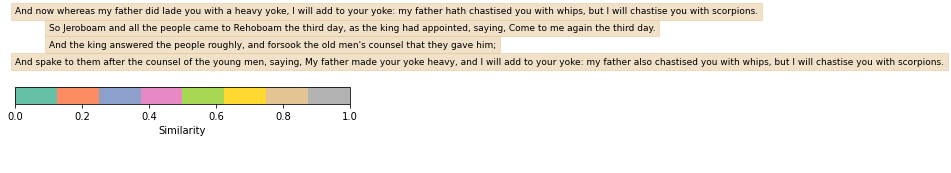

In [71]:
sentences = score['text'].values[0]
start = score['i'].values[0]
n = score['n'].values[0]
# the similarity matrix is the subset of cos_sim at the indices of the sentences (i to i+n-1)
similarity_matrix = cos_sim[start:start+n, start:start+n]
pairs = []
for i in range(len(sentences)//2):
    pairs.append((i, len(sentences) - i - 1))
if len(sentences) % 2:
    pairs.append((len(sentences)//2, len(sentences)//2))

cmap = plt.cm.get_cmap('Set2')
# fig, ax = plt.figure()
fig, ax = plt.subplots()
fs = 9
for i, pair in enumerate(pairs):
    print(i, pair)
    a = plt.text(i/10, -pair[0]/fs+1, f'{sentences[pair[0]]}',fontsize=fs)
    b = plt.text(i/10, -pair[1]/fs+1, f'{sentences[pair[1]]}',fontsize=fs)
    # make axes invisible
    plt.axis('off')
    # font family times new roman
    a.set_bbox(dict(facecolor=get_color(similarity_matrix[pair[0],pair[1]], cmap), alpha=0.5, edgecolor=get_color(similarity_matrix[pair[0],pair[1]], cmap)))
    b.set_bbox(dict(facecolor=get_color(similarity_matrix[pair[1],pair[0]], cmap), alpha=0.5, edgecolor=get_color(similarity_matrix[pair[1],pair[0]], cmap)))
    # save the figure

# when we save a Location to a string, it becomes a dict. We want the keys of the dict joined with '.'
loc = [str(v) for _,v in score["start"].items()]
name = '.'.join(loc)
# make a colorbar
# plt.colorbar('viridis')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap='Set2'),
             ax=ax, orientation='horizontal', label='Similarity', anchor=(0,8))
# plt.show()
loc = [str(v) for _,v in score["start"].values[0].items()]
print(loc)
name = '.'.join(loc)
print(name)
# plt.savefig(f'{name}_{score["n"].values[0]}.png', bbox_inches='tight')

In [ ]:
# want to 


# now we want to find the top chiasms (meaning the lowest p-values)
# group by i and keep the n with the smallest p-value
scores = scores.groupby("i").apply(lambda x: x.loc[x["p"].idxmin()]).reset_index(drop=True)
# filter by threshold
scores = scores[scores["p"] < args.thres]
# sort by p-value
scores = scores.sort_values(by="p")
# let's take the top 5 and use ENG to retrieve the passage
scores = scores.head(5)
scores['text'] = scores.apply(lambda x: retrieve_passage(x['start'], x['n']), axis=1)
print(scores.iloc[0]['text'])
# now we have them as sentences, scores['text'] is the equivalent of sentences below
cm = plt.cm.get_cmap('viridis')
for _, row in scores.iterrows():
    sentences = row['text']
    # the similarity matrix is the subset of cos_sim at the indices of the sentences (i to i+n-1)
    similarity_matrix = cos_sim[row['i']:row['i']+row['n'], row['i']:row['i']+row['n']]
    pairs = []
    for i in range(len(sentences)//2):
        pairs.append((i, len(sentences) - i - 1))
    if len(sentences) % 2:
        pairs.append((len(sentences)//2, len(sentences)//2))


    plt.figure()

    fs = 12
    for i, pair in enumerate(pairs):
        # print(i, pair)
        a = plt.text(i/10, -pair[0]/fs+1, f'{sentences[pair[0]]}',fontsize=fs)
        b = plt.text(i/10, -pair[1]/fs+1, f'{sentences[pair[1]]}',fontsize=fs)
        # make axes invisible
        plt.axis('off')
        # font family times new roman
        a.set_bbox(dict(facecolor=get_color(similarity_matrix[pair[0],pair[1]], cm), alpha=0.5, edgecolor=get_color(similarity_matrix[pair[0],pair[1]], cm)))
        b.set_bbox(dict(facecolor=get_color(similarity_matrix[pair[1],pair[0]], cm), alpha=0.5, edgecolor=get_color(similarity_matrix[pair[1],pair[0]], cm)))
        # save the figure

    # when we save a Location to a string, it becomes a dict. We want the keys of the dict joined with '.'
    loc = [str(v) for _,v in row["start"].items()]
    name = '.'.join(loc)
    # make a colorbar
    plt.colorbar('viridis')
    plt.show()
    # plt.savefig(f'{args.output}/{name}_{row["n"]}.png', bbox_inches='tight')
